## Sentiment Analysis on Winograd Document.
In this notebook, we will do simple sentiment analysis on the Winograd document, specificcally on 3 topics: military, impact on society and media. We will be using the RNN model that was trained using Stanford University's Sentiment140 dataset and using Word2Vec embedding.

### Data loading and Preprocessing

In [1]:
import pandas as pd

military_data = pd.read_csv('../data/winograd/Military.csv', encoding = "ISO-8859-1", header=None, names=['Text', 'Sentiment'])
society_data = pd.read_csv('../data/winograd/Society.csv', encoding = "ISO-8859-1", header=None, names=['Text', 'Sentiment'])
media_data = pd.read_csv('../data/winograd/Media.csv', encoding = "ISO-8859-1", header=None, names=['Text', 'Sentiment'])
military_data.head()

,Text,Sentiment
0,On September 17th 2006 The Government of Israe...,1
1,Therefore we decided to publish initially an I...,1
2,The core of the interim report is a detailed e...,0
3,We Êstart with the decision of the government ...,0
4,"TheÊ decision to respond with an immediate, in...",0


In [2]:
import re

appos = {
  "aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not",
  "doesn't" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not",
  "haven't" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "i would",
  "i'd" : "i had", "i'll" : "i will", "i'm" : "i am", "isn't" : "is not", "it's" : "it is", "it'll":"it will",
  "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not",
  "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "that's" : "that is",
  "there's" : "there is", "they'd" : "they would", "they'll" : "they will", "they're" : "they are", "they've" : "they have",
  "we'd" : "we would", "we're" : "we are", "weren't" : "were not", "we've" : "we have", "what'll" : "what will",
  "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would",
  "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not",
  "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have",
  "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"
}

def clean_text(text):
    # Remove whitespaces and make strings lowercase
    text = text.strip().lower()
    words = text.split()
    # Nagation handling
    reformed = [appos[word] if word in appos else word for word in words]
    text = " ".join(reformed)
    pattern = '(@(\w+))'                # usermention (@username)
    pattern += '|(#(\w+))'              # hashtags (#somehashtag)
    pattern += '|([^\w\s])'             # emojis 😀
    pattern += '|(\\w+:\\/\\/\\S+)'     # urls (https://google.com)
    pattern += '|(\d+)'                 # numbers
    text = ' '.join(re.sub(pattern, ' ', text).split())
    return text

military_data['CleanText'] = military_data['Text'].map(lambda t: clean_text(t))
society_data['CleanText'] = society_data['Text'].map(lambda t: clean_text(t))
media_data['CleanText'] = media_data['Text'].map(lambda t: clean_text(t))
media_data.head()

,Text,Sentiment,CleanText
0,We Êbelieve that in this way we provided all w...,1,we êbelieve that in this way we provided all w...
1,"Despite this broad support, we determine that ...",0,despite this broad support we determine that t...
2,We impose the primary responsibility for these...,0,we impose the primary responsibility for these...
3,They authorized to commence a military campaig...,0,they authorized to commence a military campaig...
4,Some of the declared goals of the war were not...,0,some of the declared goals of the war were not...


### Load RNN Model & Tokanizer

In [3]:
import pickle
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.tokenize import word_tokenize

with open('tokenizer-rnn-cnn-w2v.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)
# load rnn model
rnn_model = load_model('./models/rnn-cnn-w2v-model-04-0.8421.hdf5')

Using TensorFlow backend.


In [4]:
def make_prediction(data):
    test_sequences = tokenizer.texts_to_sequences(data['CleanText'])
    padded_test_sequences = pad_sequences(test_sequences, maxlen=35)
    y_pred = rnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)
    y_pred = pd.DataFrame(y_pred, columns=['Prediction'])
    data['Prediction'] = y_pred['Prediction'].map(lambda p: 1 if p >= 0.5 else 0)
    print(accuracy_score(data['Sentiment'], data['Prediction'])*100)

In [5]:
make_prediction(military_data)
make_prediction(society_data)
make_prediction(media_data)

13/13 [==============================] - 0s 24ms/step
53.84615384615385
10/10 [==============================] - 0s 2ms/step
60.0
11/11 [==============================] - 0s 2ms/step
45.45454545454545


## Analysis
### WordCloud

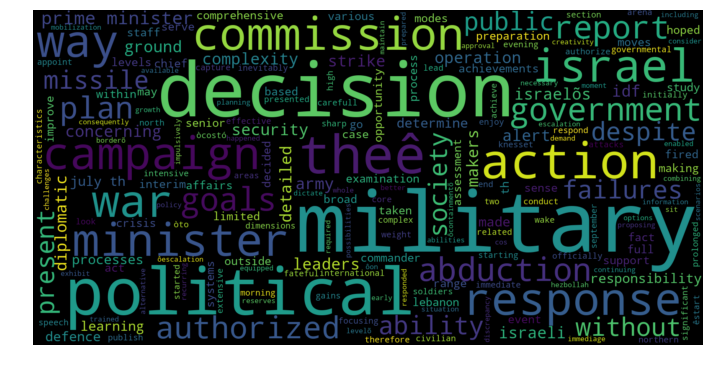

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_data = pd.concat([military_data, society_data, media_data])

# Join all the tweets in a single text
wordcloud_texts = ' '.join(all_data['CleanText'].tolist()).lower()

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(wordcloud_texts)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Piechart

In [12]:
def plot_pie_chart(positive_count, negative_count):
    # Data to plot
    labels = 'Positive', 'Negative'
    sizes = [positive_count, negative_count]
    colors = ['yellowgreen', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Sentiment Analysis on Winograd Document')
    plt.axis('equal')
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()

### Military Data

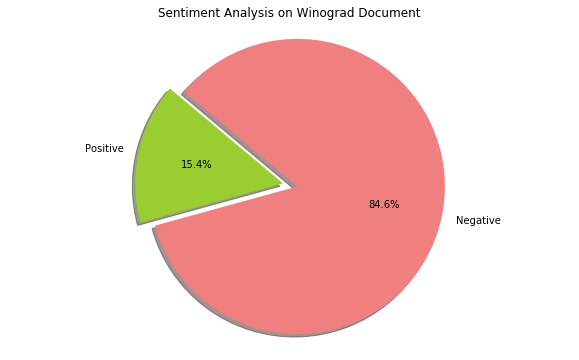

In [13]:
plot_pie_chart(military_data['Sentiment'].value_counts()[1], military_data['Sentiment'].value_counts()[0])

### Impact on Society

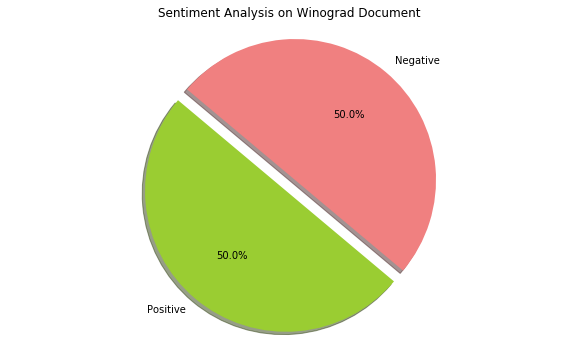

In [9]:
plot_pie_chart(society_data['Sentiment'].value_counts()[1], society_data['Sentiment'].value_counts()[0])

### Media

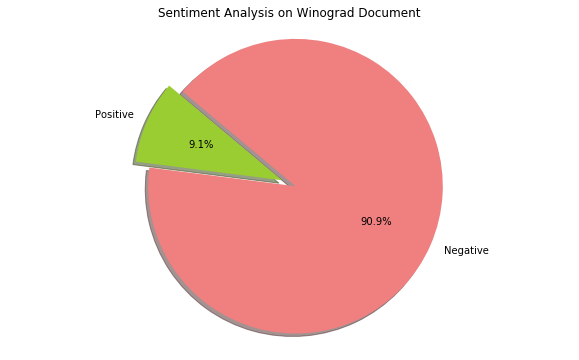

In [10]:
plot_pie_chart(media_data['Sentiment'].value_counts()[1], media_data['Sentiment'].value_counts()[0])